In [1]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

import tensorflow as tf

import params
import dataset

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [10]:
def BuildModel_SegNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('segnet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('segnet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_SegNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

def BuildModel_UNet():
    inp = Input(shape=(params.GetImageSize(), params.GetImageSize(), params.GetChannelsNum()))

    conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
    conv_1_1 = Activation('relu')(conv_1_1)
    conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
    conv_1_2 = Activation('relu')(conv_1_2)
    pool_1 = MaxPooling2D(2)(conv_1_2)

    conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
    conv_2_1 = Activation('relu')(conv_2_1)
    conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
    conv_2_2 = Activation('relu')(conv_2_2)
    pool_2 = MaxPooling2D(2)(conv_2_2)

    conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
    conv_3_1 = Activation('relu')(conv_3_1)
    conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
    conv_3_2 = Activation('relu')(conv_3_2)
    pool_3 = MaxPooling2D(2)(conv_3_2)

    up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
    conc_1 = Concatenate()([conv_3_2, up_1])
    conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(up_1)
    conv_up_1_1 = Activation('relu')(conv_up_1_1)
    conv_up_1_2 = Conv2D(256, (3, 3), padding='same')(conv_up_1_1)
    conv_up_1_2 = Activation('relu')(conv_up_1_2)

    up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
    conc_2 = Concatenate()([conv_2_2, up_2])
    conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(up_2)
    conv_up_2_1 = Activation('relu')(conv_up_2_1)
    conv_up_2_2 = Conv2D(128, (3, 3), padding='same')(conv_up_2_1)
    conv_up_2_2 = Activation('relu')(conv_up_2_2)

    up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
    conc_3 = Concatenate()([conv_1_2, up_3])
    conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(up_3)
    conv_up_3_1 = Activation('relu')(conv_up_3_1)
    conv_up_3_2 = Conv2D(4, (3, 3), padding='same')(conv_up_3_1)
    result = Activation('sigmoid')(conv_up_3_2)
    
    return Model(inputs=inp, outputs=result)

best_w = keras.callbacks.ModelCheckpoint('unet_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=False,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('unet_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=False,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]


model = BuildModel_UNet()
adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(adam, 'categorical_crossentropy')

In [11]:
data = dataset.read_train_validation_big_sets(
        train_path = os.path.join(params.training_data_path),
        validation_path = os.path.join(params.validation_data_path),
        image_size = params.GetImageSize())

print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(data.train.num_examples))
print("Number of files in Validation-set:\t{}".format(data.valid.num_examples))

Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		40
Number of files in Validation-set:	8


img_df = data.train.image_paths
mask_df = data.train.masks_paths
batch_size = 26

index = 0
while index < 5:
    x_batch = []
    y_batch = []
    r_batch = []

    for i in range(batch_size):
        img_name = img_df[index]
        mask_name = mask_df[index]

#             print(index, img_name, mask_name)

        index = (index + 1) % len(img_df)

        img = cv2.imread(img_name, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)

#             img, mask

        img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
        mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            

        height, width = mask.shape
        masks = np.zeros((height, width, 4))
        for i in range(masks.shape[2]):
            masks[:, :, i] = (mask == (i+1))

        #moving the channel:
        mask_train = np.moveaxis(masks,-1,1)

        x_batch += [img]
        y_batch.append(mask_train)
        r_batch += [mask]

    x_batch = np.array(x_batch) / 255.
    y_batch = np.array(y_batch) / 255.
    r_batch = np.array(r_batch) / 255.

x_batch.shape,y_batch.shape,r_batch.shape

In [14]:
def keras_generator(img_df, mask_df, batch_size):
    index = 0
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name = img_df[index]
            mask_name = mask_df[index]
            
#             print(index, img_name, mask_name)
            
            index = (index + 1) % len(img_df)
            
            img = cv2.imread(img_name, cv2.IMREAD_COLOR)
            mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
            
#             img, mask
            
            img = cv2.resize(img, (params.GetImageSize(), params.GetImageSize()))
            mask = cv2.resize(mask, (params.GetImageSize(), params.GetImageSize()))            
            
            height, width = mask.shape
            masks = np.zeros((height, width, 4))
            for i in range(masks.shape[2]):
                masks[:, :, i] = (mask == (i+1))
            
#             masks = np.moveaxis(masks,-1,1)
            
            x_batch += [img]
            y_batch.append(masks)

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch) / 1.
        
#         print(x_batch.shape,y_batch.shape)

        yield x_batch, y_batch

In [15]:
batch_size = 16
model.fit_generator(keras_generator(data.train.image_paths, data.train.masks_paths, batch_size),
              steps_per_epoch=100,
              epochs=3,
              verbose=1,
              callbacks=callbacks,
              validation_data=keras_generator(data.valid.image_paths, data.valid.masks_paths, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=True,
              shuffle=True,
              initial_epoch=0)

Epoch 1/3
5/5 [==============================] - 141s 28s/step - loss: 1.3749 - val_loss: 1.3444
Epoch 2/3
5/5 [==============================] - 134s 27s/step - loss: 1.2893 - val_loss: 1.1282
Epoch 3/3
5/5 [==============================] - 135s 27s/step - loss: 0.9292 - val_loss: 0.5179


from keras.models import load_model

model1 = BuildModel_SegNet()
model1.load_weights('unet_best.h5')
# model1 = load_model('unet_best.h5')

In [16]:
from keras.models import load_model
model1 = load_model('segnet_best.h5')
# model1 = load_model('unet_best.h5')

In [17]:
for x, y in keras_generator(data.valid.image_paths, data.valid.masks_paths, 16):
    break

In [18]:
pred = model1.predict(x)

In [19]:
pred[0].shape

(256, 256, 4)

In [20]:
sample_index = 0
keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).shape

(256, 256)

In [21]:
def getClassesMap(pred):
    res = np.zeros((pred.shape[0], pred.shape[1]), np.uint8)
    for r in range(pred.shape[0]):
        for c in range(pred.shape[1]):
            pred_class_index = np.argmax(pred[r,c,:])
            res[r,c] = pred_class_index
    res.shape
    return res

In [22]:
getClassesMap(pred[sample_index]).shape

(256, 256)

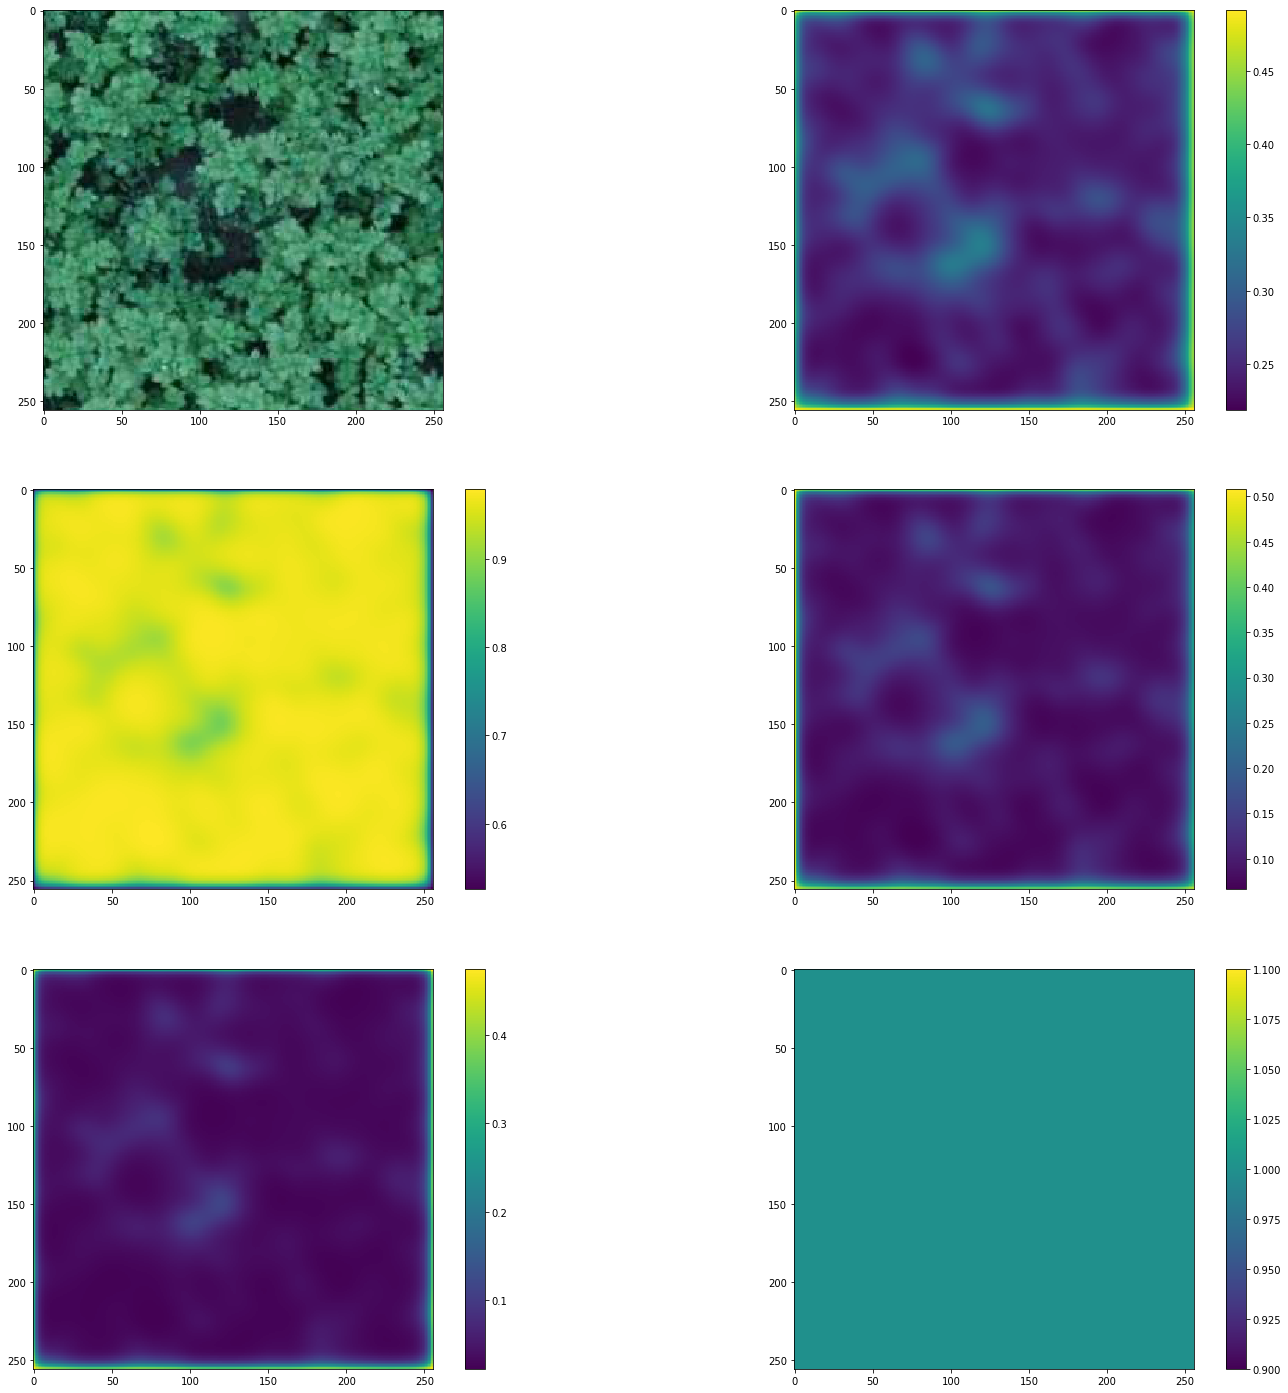

In [23]:
sample_index = 1
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(25, 25))
axes[0][0].imshow(x[sample_index])
im_0_1 = axes[0][1].imshow(pred[sample_index, ..., 0])
im_1_0 = axes[1][0].imshow(pred[sample_index, ..., 1])
im_1_1 = axes[1][1].imshow(pred[sample_index, ..., 2])
im_2_0 = axes[2][0].imshow(pred[sample_index, ..., 3])
# im_2_1 = axes[2][1].imshow(keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)).astype(np.float32))
im_2_1 = axes[2][1].imshow(getClassesMap(pred[sample_index]))
# im_2_1 = axes[2][1].imshow(pred[sample_index, 20:40, 0:5, 0])

plt.colorbar(im_0_1, ax=axes[0,1])
plt.colorbar(im_1_0, ax=axes[1,0])
plt.colorbar(im_1_1, ax=axes[1,1])
plt.colorbar(im_2_0, ax=axes[2,0])
plt.colorbar(im_2_1, ax=axes[2,1])

plt.show()

In [24]:
np.max(pred[sample_index, 20:40, 0:5, 3])

0.30947465

In [25]:
pred[sample_index][15,110,:]

array([0.26494905, 0.95540196, 0.10256102, 0.04407096], dtype=float32)

In [26]:
np.exp(pred[sample_index][15,110,:])/sum(np.exp(pred[sample_index][15,110,:]))

array([0.2152137 , 0.42926928, 0.18295561, 0.17256145], dtype=float32)

In [27]:
a=pred[sample_index][15,110,:]
np.argmax(a)

1

In [28]:
keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2))

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [29]:
y[sample_index][:,:,0].shape

(256, 256)

In [30]:
keras.backend.eval(tf.keras.backend.argmax(pred[sample_index], 2)) == (y[sample_index][:,:,1])

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]])

In [31]:
sample_index = 1

ok_cnt = 0
errors = {
    0: [0,0,0,0],
    1: [0,0,0,0],
    2: [0,0,0,0],
    3: [0,0,0,0],
}
for r in range(y[sample_index].shape[0]):
    for c in range(y[sample_index].shape[1]):
        pred_class_index = np.argmax(pred[sample_index][r,c,:]) + 0
        real_class_index = np.argmax(y[sample_index][r,c,:])
#         print(r,c,pred_class_index, real_class_index)
        if pred_class_index == real_class_index:
            ok_cnt = ok_cnt + 1
        else:
            errors[real_class_index][pred_class_index] = errors[real_class_index][pred_class_index] + 1
        

In [32]:
ok_cnt,errors

(60470,
 {0: [0, 2065, 0, 0], 1: [0, 0, 0, 0], 2: [0, 3001, 0, 0], 3: [0, 0, 0, 0]})